# Transformers From Scratch

Transformers are one of the most powerful deep learning models we have today. They are the culmination of a handful of key insights from ML research from the last decade.

In this notebook, we will build up these key insights from the ground-up, from tokenization to multi-head-attention, and eventually assemble different Transformer architecures (BERT, GPT) and finally train a GPT-2 like language model.

In [1]:
import re
import math
import scipy
import numpy as np
from collections import Counter, defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

## 1. Byte Pair Encoding (BPE) - Creating a vocabulary and tokenizing text to numbers

The first problem of having machines understand text input is to convert human language into machine-friendly format i.e. numbers. We could collect all the words we can find and assign them an integer (as was geneally done in classical NLP), but it has following problems:

1. There are more than 1 million words in english language alone.
2. How do we incorporate new and unknown words? Natural language is infinitely productive.
3. Encoding language with a very large size vocabulary is problematic (both compute and modeling wise).

Instead of using words, can we map all the characters instead to integers? The problem is characters don't have semantic meaning in themselves.

Byte-pair Encoding aims to solve all of these problems. The key idea is to start by breaking up all the words into characters, then merge the most commonly occuring pairs of characters or sub-words. Works great - GPT models are able to learn from the "entirety of human knowledge" using vocabulary size of just 50257 Let us implement BPE step by step.

Step 1: Separate each char in word by space and add mark end of token, count frequency of tokens in corpus.

In [2]:
def build_vocab(corpus):
    tokens = [" ".join(word) + " </w>" for word in corpus.split()]
    # Count frequency of tokens in corpus
    vocab = Counter(tokens)  
    return vocab

Step 2: Get counts of pairs of consecutive symbols (characters or sub-words).

In [3]:
def get_stats(vocab):
    pairs = Counter()
    for word, frequency in vocab.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pairs[symbols[i], symbols[i + 1]] += frequency
    return pairs

Step 3: Merge the most frequent pairs in the vocabulary.

In [4]:
def merge_vocab(pair, v_in):
    v_out = Counter()
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

After building the vocabulary by merging most common subwords, use it to convert text to sequence of sub-words. We use `</w>` to denote that this token should be the end token of a word.

In [5]:
def tokenize(string, sorted_tokens, input_id_map, return_strings=False, max_length=32, unknown_token='</u>'):
    
    string = " ".join([s+'</w>' for s in string.split(" ")])
    
    def tokenize_words(string, sorted_tokens, unknown_token):
        if string == '':
            return []
        if sorted_tokens == []:
            return [unknown_token]

        string_tokens = []
        for i in range(len(sorted_tokens)):
            token = sorted_tokens[i]
            token_reg = re.escape(token.replace('.', '[.]'))

            matched_positions = [(m.start(0), m.end(0)) for m in re.finditer(token_reg, string)]
            if len(matched_positions) == 0:
                continue
            substring_end_positions = [matched_position[0] for matched_position in matched_positions]

            substring_start_position = 0
            for substring_end_position in substring_end_positions:
                substring = string[substring_start_position:substring_end_position]
                string_tokens += tokenize_words(string=substring, sorted_tokens=sorted_tokens[i+1:], unknown_token=unknown_token)
                string_tokens += [token]
                substring_start_position = substring_end_position + len(token)
            remaining_substring = string[substring_start_position:]
            string_tokens += tokenize_words(string=remaining_substring, sorted_tokens=sorted_tokens[i+1:], unknown_token=unknown_token)
            break
        return string_tokens
    
    tokens = tokenize_words(string, sorted_tokens, unknown_token)
    if return_strings: return tokens
    if max_length == -1: return [input_id_map[t] for t in tokens]
    input_ids = [1] * max_length
    attention_mask = [0] * max_length
    for i, t in enumerate(tokens):
        input_ids[i] = input_id_map[t]
        attention_mask[i] = 1
    return input_ids, attention_mask

Example: Creating a vocabualry out of all the works of William Shakespeare. We can adjust the `num_merges` parameter to control the granularity of tokens.

In [6]:
with open('temp/Tiny Shakespeare.txt', 'r') as f:
    corpus = f.read()

vocab = build_vocab(corpus)
num_merges = 4000
for i in tqdm(range(num_merges)):
    pairs = get_stats(vocab)
    if not pairs:
        break
    best = max(pairs, key=pairs.get)
    vocab = merge_vocab(best, vocab)

  0%|          | 0/4000 [00:00<?, ?it/s]

Now lets take a peek into the tokens created from this corpus.

In [7]:
def get_tokens_from_vocab(vocab):
    tokens_frequencies = Counter()
    vocab_tokenization = {}
    for word, freq in vocab.items():
        word_tokens = word.split()
        for token in word_tokens:
            tokens_frequencies[token] += freq
        vocab_tokenization[''.join(word_tokens)] = word_tokens
    return tokens_frequencies, vocab_tokenization

After merging 4000 times, we have generated 3813 tokens from our corpus.

In [8]:
tokens_frequencies, vocab_tokenization = get_tokens_from_vocab(vocab)
print('Number of tokens: {}'.format(len(tokens_frequencies.keys())))
print('Most common 20 tokens: {}'.format(tokens_frequencies.most_common(20)))

Number of tokens: 3813
Most common 20 tokens: [('the</w>', 5457), ('I</w>', 4421), ('to</w>', 3961), ('and</w>', 3704), ('of</w>', 3311), ('a</w>', 2749), ('my</w>', 2694), ('in</w>', 2285), ('you</w>', 2132), ('that</w>', 1817), ('And</w>', 1801), ('is</w>', 1790), ('not</w>', 1649), ('with</w>', 1573), ('be</w>', 1500), ('your</w>', 1497), ('for</w>', 1396), ('his</w>', 1392), ('it</w>', 1307), ('have</w>', 1281)]


Now lets create the mapping of tokens to integers and back.

In [9]:
def measure_token_length(token):
    return len(token[:-4]) + 1 if token[-4:] == '</w>' else len(token)
    
sorted_tokens = [
    token
    for (token, freq) in sorted(
        tokens_frequencies.items(),
        key=lambda item: (measure_token_length(item[0]), item[1]),
        reverse=True,
    )
]

We also create two special tokens: unknown (`</u>`) which is used when a token is not present in our vocabulary and padding (`</p>`) which helps us create fixed length arrays of tokens to use as input.

In [10]:
UNK_TOKEN = '</u>'
PAD_TOKEN = '</p>'

token2id = { UNK_TOKEN: 0, PAD_TOKEN:1}
for i, token in enumerate(sorted_tokens):
    token2id[token] = i+2

id2token = {v:k for k, v in token2id.items()}

In [11]:
vocab_size = len(token2id)
vocab_size

3815

Finally we can use our tokenzier to get token list and its corresponding integer list.

In [12]:
max_len = 64

input_text = 'I am the first king of england'

tokenized = tokenize(input_text,
                     sorted_tokens=sorted_tokens,
                     input_id_map=token2id,
                     return_strings=True,
                     max_length=max_len,
                     unknown_token='</u>')
print(tokenized)

['I</w>', 'am</w>', 'the</w>', 'first</w>', 'king</w>', 'of</w>', 'eng', 'land</w>']


In [13]:
input_ids, attention_mask = tokenize(input_text,
                     sorted_tokens=sorted_tokens,
                     input_id_map=token2id,
                     return_strings=False,
                     max_length=max_len,
                     unknown_token='</u>')
print(input_ids)
print(attention_mask)

[3418, 2715, 1876, 623, 1149, 2686, 3371, 1266, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Now that we have a dynamic mapping of words into sub-words and their integers, we can use this representation with machines. However, these integers have semantic meaning, and we want to get rid of that. Additionally, we want the models to dynamically learn the semantic meaning of the words during the training.

For this, we create a mapping of integers to random vectors which are called word embeddings. We can give arbitrary dimension to these vectors, however the larger the dimension the more information they can encode and consequently increase the overall compute requirement for algorithms that use it.

In [14]:
emb_dim = 32

token_embeddings = nn.Embedding(vocab_size, emb_dim)
token_embeddings.weight.size() # vocab_size x embedding_dim

torch.Size([3815, 32])

In [15]:
with torch.no_grad():
    input_embeddings = token_embeddings(torch.Tensor(input_ids).long())

input_embeddings

tensor([[ 1.1626,  0.0797,  0.6972,  ...,  0.0084,  0.6901, -1.2833],
        [-0.2049,  0.2148,  1.6585,  ...,  0.7465, -1.4797,  1.7816],
        [ 2.1851, -1.5042,  0.7744,  ..., -1.6813, -0.5905, -0.3054],
        ...,
        [-0.0493,  0.7197,  1.3134,  ...,  1.1167,  0.4977, -0.6197],
        [-0.0493,  0.7197,  1.3134,  ...,  1.1167,  0.4977, -0.6197],
        [-0.0493,  0.7197,  1.3134,  ...,  1.1167,  0.4977, -0.6197]])

In [16]:
input_embeddings.size() # max_len x embedding_dim

torch.Size([64, 32])

## 2. Positional Encoding - Incorporating the order of words

Langugage is inherently sequential, and the order of the words/tokens is very important. We want to incorporate the position of the tokens in the sequence while modeling. 

Positional encoding, the solution, adds a time signal to the input. This is necessary because unlike RNNs, there is no recurrence built into Transformers which carries positional information in the network architecture itself. Embeddings could be learnt, but doesn't generalize well to positions not seen in the training data.

The ideal criteria for positional information encoding are:
1. It should output a unique encoding for each time-step
2. Distance between any two time-steps should be consistent across sequences with different lengths.
3. Our model should generalize to longer sentences without any efforts. Its values should be bounded.
4. It must be deterministic.


The proposed technique in the original 2017 paper is to generate a $d$ dimensional vector PE such that $d_{\text {word embedding }}=d_{\text {postional embedding }}$ (one for each element of the sequence) and add it to the input vectors, defined as:

$$
P E_{(p o s, i)}=\left\{\begin{array}{ll}
\sin \left(\frac{p o s}{10000^{i d_{\text {model }}}}\right) & \text { if } i \bmod 2=0 \\
\cos \left(\frac{p o s}{10000^{j d_{\text {thotel }}}}\right) & \text { otherwise }
\end{array}\right.
$$



Lets create matrix of `[SeqLen, HiddenDim]` representing the positional encoding for `max_len` inputs.

In [17]:
pe = torch.zeros(max_len, emb_dim)
pe.size()

torch.Size([64, 32])

And lets implement the above PE formula to create these position vectors for each position upto the `max_len` inputs our transformer is designed to take (also known as context window).

In [18]:
position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
print(position.T)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
         28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
         42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
         56., 57., 58., 59., 60., 61., 62., 63.]])


In [19]:
div_term = torch.exp(torch.arange(0, emb_dim, 2).float() * (-math.log(10000.0) / emb_dim))
div_term

tensor([1.0000e+00, 5.6234e-01, 3.1623e-01, 1.7783e-01, 1.0000e-01, 5.6234e-02,
        3.1623e-02, 1.7783e-02, 1.0000e-02, 5.6234e-03, 3.1623e-03, 1.7783e-03,
        1.0000e-03, 5.6234e-04, 3.1623e-04, 1.7783e-04])

In [20]:
pos_sin = torch.sin(position * div_term)
pos_cos = torch.cos(position * div_term)
pos_sin.size(), pos_cos.size()

(torch.Size([64, 16]), torch.Size([64, 16]))

In [21]:
pe[:, 0::2] = pos_sin
pe[:, 1::2] = pos_cos
pe.size()

torch.Size([64, 32])

Wrapping it all into a function, we have:

In [22]:
def position_encode(max_len, emb_dim):
    pe = torch.zeros(max_len, emb_dim)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, emb_dim, 2).float() * (-math.log(10000.0) / emb_dim))
    pos_sin = torch.sin(position * div_term)
    pos_cos = torch.cos(position * div_term)
    pe[:, 0::2] = pos_sin
    pe[:, 1::2] = pos_cos
    return pe
position_encode(64, 32).size()

torch.Size([64, 32])

We can visualize the values of these positional encoding vectors as follows:

In [23]:
def plot_matrix(mat, xlabel, ylabel, figsize=(10, 10), ticklabels=None):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    pos = ax.imshow(mat, cmap='PuBuGn', extent=(1,mat.shape[1]+1,mat.shape[0]+1,1))
    fig.colorbar(pos, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if not ticklabels:
        ax.set_xticks([1]+[i*10 for i in range(1,1+mat.shape[1]//10)])
        ax.set_yticks([1]+[i*10 for i in range(1,1+mat.shape[0]//10)])
    else:
        ax.set_xticklabels(ticklabels[0])
        ax.set_yticklabels(ticklabels[1])
    plt.show()

We can observe that each position vector consists of periodic waves (sien/cosine) of different frequency in each dimension, giving this interesting visualization.

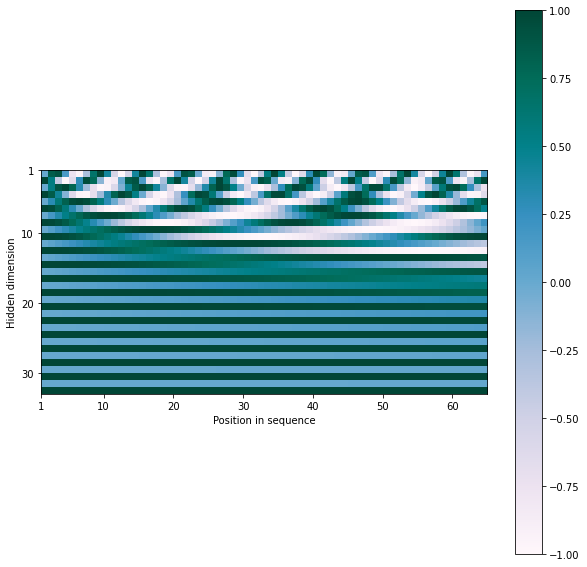

In [24]:
plot_matrix(pe.T.squeeze().numpy(), xlabel="Position in sequence", ylabel="Hidden dimension")

Finally, to incorporate positional information into our token embeddings, we simply add the positional encoding vectors of embedding lengths to the input word/token embeddings.

In [25]:
x = input_embeddings + pe
x

tensor([[ 1.1626,  1.0797,  0.6972,  ...,  1.0084,  0.6901, -0.2833],
        [ 0.6365,  0.7551,  2.1917,  ...,  1.7465, -1.4795,  2.7816],
        [ 3.0944, -1.9204,  1.6765,  ..., -0.6813, -0.5901,  0.6946],
        ...,
        [-1.0154,  0.4616,  1.5653,  ...,  2.1166,  0.5086,  0.3802],
        [-0.7885,  1.3932,  1.0106,  ...,  2.1165,  0.5087,  0.3802],
        [ 0.1181,  1.7056,  0.5491,  ...,  2.1165,  0.5089,  0.3802]])

In [26]:
x.size()

torch.Size([64, 32])

### Input text to output text

With BPE and Positional encoding, we now have way to represent text as ordered numerical vectors. But how do we produce the output text?
We can do this by outputing a probability distribution over the entire vocabulary size.

The following 2 layer neural network shows how we can input text into a neural network and get text out.

In [27]:
w1 = torch.randn(emb_dim, emb_dim, dtype=torch.float32)
b1 = torch.randn(max_len, 1, dtype=torch.float32)

w2 = torch.randn(emb_dim, vocab_size, dtype=torch.float32)
b2 = torch.randn(max_len, 1, dtype=torch.float32)

output = x @ w1 + b1
output = nn.ReLU()(output)

output = output @ w2 + b2
output = F.softmax(output, dim=-1)

In [28]:
output.argmax(1)

tensor([3457, 2911, 1559, 3171, 2868,   25, 2045, 1798,  874, 1798, 2120, 2120,
        2120, 2120, 2120, 2120, 2120, 2120, 2120, 2120, 2120, 2120, 2120, 2120,
        2120, 2120, 2120, 2120, 2120, 2120, 2120,  874,  874,  874, 2120,  874,
        2120, 2120, 2120, 2120, 2120, 2120, 2120, 2120,  874,  874,  874,  874,
        2120,  874,  874,  874,  874,  874,  874, 2120, 2120, 2120, 2120, 2120,
        2120, 2120,  874, 3296])

In [29]:
print([id2token[i] for i in output.argmax(1).tolist()])

['or', 'don', 'man;</w>', 'ian', 'pas', 'ANTIGONUS:</w>', 'with', 'red,</w>', 'fault</w>', 'red,</w>', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'fault</w>', 'fault</w>', 'fault</w>', 'requ', 'fault</w>', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'fault</w>', 'fault</w>', 'fault</w>', 'fault</w>', 'requ', 'fault</w>', 'fault</w>', 'fault</w>', 'fault</w>', 'fault</w>', 'fault</w>', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'requ', 'fault</w>', 'nor']


### Learned positional encoding vs fixed

Why do we manually design static positional encoding? Why not let the network learn its own positional vectors?

In fact, many modern recent use learnable positional encoding. Sinusoid encoding was introduced by the original Transformers paper and seems to do the job well. Many learned positional encoding tend to learn similar encoding to the sinusoid ones, along with other useful positional attributes encoded in the other domains of these vectors.

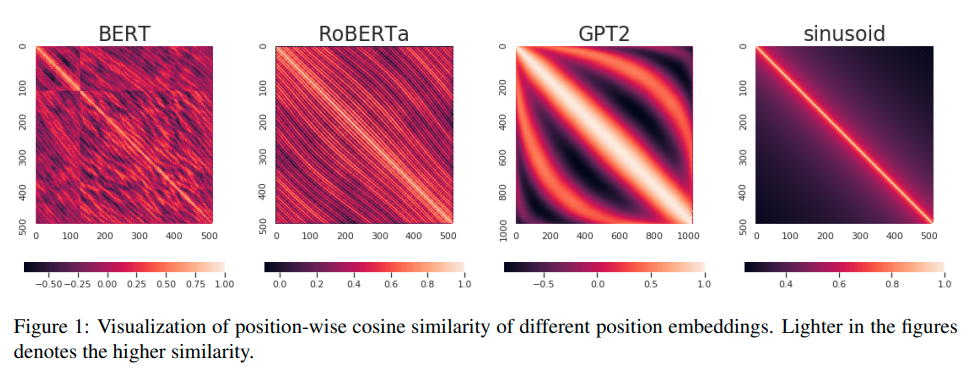
[Source: Wang et al.](https://arxiv.org/abs/2010.04903)

> Transformer encoders learn the local position information that can only be effective in masked language
modeling. On the other hand, the Transformer decoders for autoregressive language modeling actually learn about absolute positions. The empirical experiments on the pre-trained position embeddings validate our hypothesis. We also show that different NLP tasks with different model architectures and different training objectives may utilize
the position information in different ways.

### Positional Encoding as PyTorch Module

We can use the `position_encode` function above to create PyTorch module that we can use in architectures. We also enable using learned positional embeddings.

In [30]:
class PositionalEncoding(nn.Module):

    def __init__(self, emb_dim, max_len, sinusoidal=True):
        """
        Inputs
            emb_dim - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()
        self.sinusoidal = sinusoidal
        if self.sinusoidal:
            pe = position_encode(max_len, emb_dim).unsqueeze(0) # add dim to the start to handle batch size
            self.register_buffer('pe', pe, persistent=False)
        else:
            self.register_buffer('pos', torch.arange(0, max_len, dtype=torch.long).unsqueeze(0))
            self.pe = nn.Embedding(max_len, emb_dim)

    def forward(self, x):
        if self.sinusoidal:
            return x + self.pe[:, :x.size(1)]
        else:
            return x + self.pe(self.pos[:, :x.size(1)])

## 3. Self Attention - Enabling model to learn relationship between tokens

The concept of attention tries to incorporate this question into network architecture: How relevant is the ith element in the sequence relative to other elements in the same sequence?

Basic idea:
- don't try to learn one global representation for the source sequence (encoder)
- rather learn context-sensitive token representations
- when generating a target token, dynamically combine the most relevant source representations

There is one Q, K and V vector for each sequence element, which are used to compute attention vectors for every element.

**Query**: The query is a vector that describes what a token is looking for in other tokens, i.e. what would we maybe want to pay attention to.

**Keys**: The key vector roughly describes what a token is “offering” with respect to the query, or when it might be important. 

**Value**: The value vector represents the actual content of the token. It is used as a part of the weighted sum to compute each output vector.

$$
\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V
$$

By attention weighting the tokens, we can generate abstract concepts starting from word embeddings.

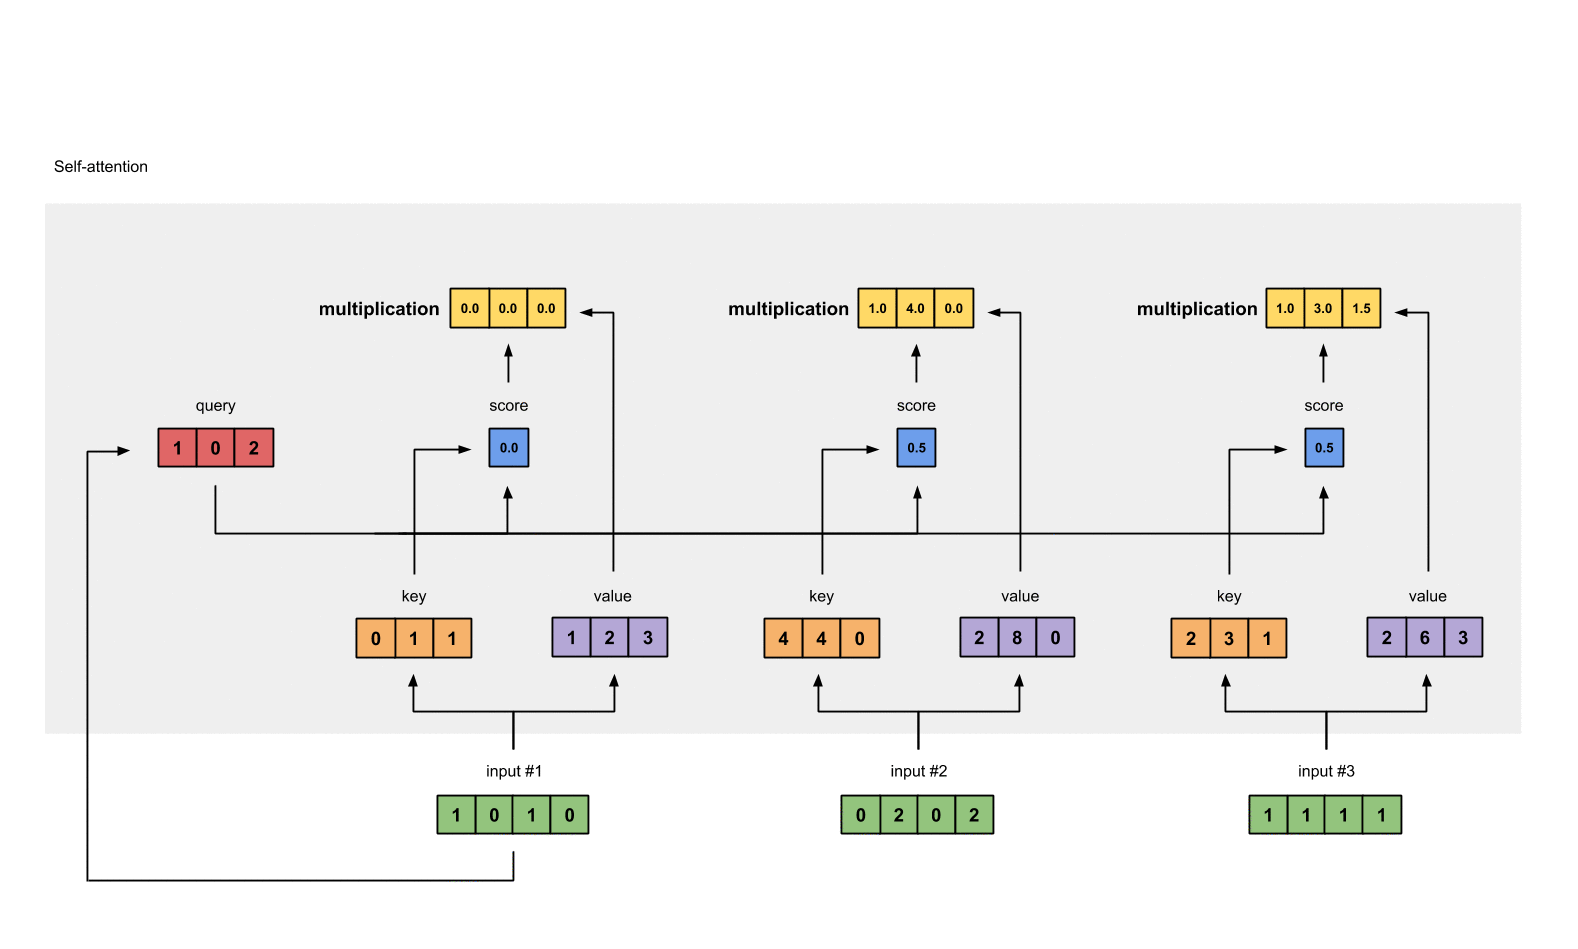
[Source [4]](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a)

### Attention Example with Pretrained embeddings

To observe how self-attention mechanism enables combining lower-level concepts to create abstractions at higher levels, lets use shallow word embeddings and observe creation of abstract concepts via mixing with attention.

In [32]:
from scipy.special import softmax
import gensim.downloader as api
w_emb = api.load('fasttext-wiki-news-subwords-300')

In [33]:
w_pos = position_encode(100, 300)

In [34]:
def cosine_similarity(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

Lets use an example text "Cows and huts and fields" to denote the concept of a rual place.

In [35]:
text = "cows and huts and fields"
tokens = text.split()
tokens

['cows', 'and', 'huts', 'and', 'fields']

Lets add positional encoding vectors to the word embeddings for the tokens of the given example text.

In [36]:
token_vectors = [w_emb[t] + w_pos[i].numpy()*0.001 for i, t in enumerate(tokens)]
# token_vectors = [w_emb[t] for i, t in enumerate(tokens)]

The following is a non-vectorized implementation of self-attention for our example use.

In [37]:
d_emb = 300
wq = np.random.normal(1, 1e-4, d_emb)
wk = np.random.normal(1, 1e-5, d_emb)
wv = np.random.normal(1, 1e-9, d_emb)

def simple_attention(token_vectors, wq, wk, wv, d_emb):
    attention_scores = []
    values = []
    for token in token_vectors:
        q = token * wq
        v = token * wv
        
        similarities = []
        for token_k in token_vectors:
            k = token_k * wk
            sim = np.dot(q, k) / np.sqrt(d_emb)
            similarities.append(sim)

        score = softmax(np.stack(similarities))
        attention_scores.append(score)
        values.append(v)
    
    # Final output tokens are the weighted sum of attention scores of tokens and their value vectors.
    outputs = []
    for i in range(len(token_vectors)):
        val = np.zeros(d_emb)
        for j in range(len(token_vectors)):
            val += attention_scores[i][j] * values[j]
        outputs.append(val)
    
    return attention_scores, outputs

We get two values from the function. The first is the attention weights, which signifies how each token may be influenced by the other. The second is the output vector, which is the sum of token embeddings weighted by their attention scores.

In [38]:
attention, outputs = simple_attention(token_vectors, wq, wk, wv, d_emb)

We can visualize the attention values has a heatmp between the tokens.

<ipython-input-23-cd247f3ed1e3>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticklabels[0])
<ipython-input-23-cd247f3ed1e3>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticklabels[1])


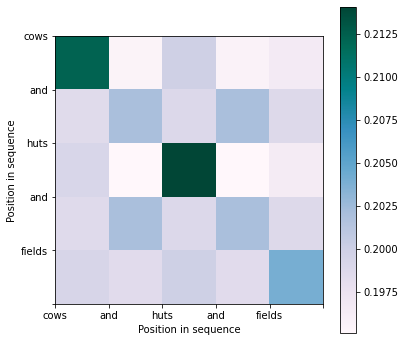

In [39]:
plot_matrix(np.stack(attention), xlabel="Position in sequence",
            ylabel="Position in sequence", figsize=(6, 6), ticklabels=(text.split(), text.split()))

Here, we see that after mixing word embeddings using attention, the concept that arises is closer to the notion of "village" rather than "city".

In [40]:
cosine_similarity(w_emb["city"], np.mean(outputs, axis=0))

0.4447383956902817

In [45]:
cosine_similarity(w_emb["village"], np.mean(outputs, axis=0))

0.5557934201099707

### How attention is implemented

In practice, self-attention is implemented efficiently as shown below.

In [46]:
w1_key = torch.randn(max_len, emb_dim, dtype=torch.float32, requires_grad=False)
w1_query = torch.randn(max_len, emb_dim, dtype=torch.float32, requires_grad=False)
w1_value = torch.randn(max_len, emb_dim, dtype=torch.float32, requires_grad=False)

In [47]:
w1_key.size(), w1_query.size(), w1_value.size()

(torch.Size([64, 32]), torch.Size([64, 32]), torch.Size([64, 32]))

In [48]:
k = x @ w1_key.T
q = x @ w1_query.T
v = x @ w1_value.T

In [49]:
k.size(), q.size(), v.size()

(torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 64]))

In [50]:
attn_logits = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(q.size()[-1])

In [51]:
attention = F.softmax(attn_logits, dim=-1)

In [52]:
values = attention @ v

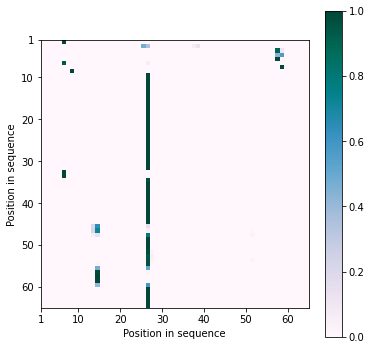

In [53]:
plot_matrix(attention.numpy(), xlabel="Position in sequence",
            ylabel="Position in sequence", figsize=(6, 6))

Wrapping the whole operation into a single function, we have:

In [54]:
def scaled_dot_product_attention(q, k, v, mask=None):
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(q.size()[-1])
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [55]:
values, attention = scaled_dot_product_attention(q, k, v, mask=torch.Tensor(attention_mask).long())
values.size(), attention.size()

(torch.Size([64, 64]), torch.Size([64, 64]))

### Inductive Bias using Attention Mask

We can also provide attention masks to constraint the attention mechanism to attend only to tokens that we want. The most common example of doing this using "causal mask", which allows attention to only look in the left tokens. This enables model to learn the "causal" relationship between the tokens.

This is generally used to train time-series models and langugage models.

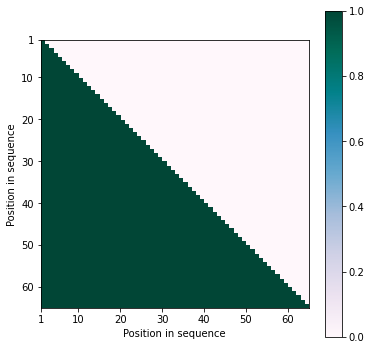

In [56]:
causal_mask = torch.tril(torch.ones(max_len, max_len))
plot_matrix(causal_mask.numpy(), xlabel="Position in sequence",
            ylabel="Position in sequence", figsize=(6, 6))

### Multi-head Attention

To account for the fact that an element in sequence can have multiple interpretation or different relation to neighbors, we can combine several attention mechanisms with "multi-head" attention. For example, one attention "head" might focus on grammatical structure, another may focus on semantic relationship between tokens.

We generate and use multiple sets of Q,K,V vectors, and do the same process as a single attention mechanism.

In [57]:
w2_key = torch.randn(max_len, emb_dim, dtype=torch.float32)
w2_query = torch.randn(max_len, emb_dim, dtype=torch.float32)
w2_value = torch.randn(max_len, emb_dim, dtype=torch.float32)

k2 = x @ w2_key.T
q2 = x @ w2_query.T
v2 = x @ w2_value.T

values2, attention2 = scaled_dot_product_attention(q2, k2, v2, mask=torch.Tensor(attention_mask).long())

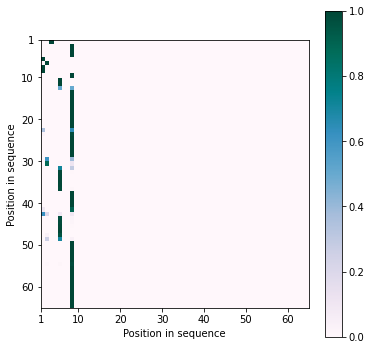

In [58]:
plot_matrix(attention2.numpy(), xlabel="Position in sequence",
            ylabel="Position in sequence", figsize=(6, 6))

### Multi-head Attention as PyTorch Module

The following is the full implementation of multi-head attention as a PyTorch module.

In [59]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, emb_dim, num_heads, max_len):
        super().__init__()
        assert emb_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        self.qkv_proj = nn.Linear(input_dim, 3*emb_dim)
        self.o_proj = nn.Linear(emb_dim, emb_dim)
        self.register_buffer("causal_mask", torch.tril(torch.ones(max_len, max_len)).view(1, 1, max_len, max_len))
        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        self.o_proj.bias.data.fill_(0)
        
    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # If mask is defined, use it. Else, use causal mask.
        if mask is None:
            mask = self.causal_mask[:,:,:seq_length,:seq_length].expand(batch_size, self.num_heads, -1, -1)
        else:
            mask = mask.view(batch_size, 1, 1, seq_length).expand(-1, self.num_heads, seq_length, -1)
        values, attention = scaled_dot_product_attention(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.emb_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

x = (input_embeddings + pe).unsqueeze(0) # add batch dimenstion

mha = MultiheadAttention(input_dim=32, emb_dim=32, num_heads=2, max_len=128)
mha(x)

tensor([[[ 1.5108,  0.8793, -1.4596,  ..., -1.0245,  0.2531, -0.0374],
         [ 0.9224,  0.4024, -1.0509,  ..., -0.3668, -0.7619, -0.5811],
         [ 1.2484,  0.5134, -0.4724,  ...,  0.5601, -0.3479, -0.1899],
         ...,
         [ 0.5140,  0.6936,  1.1067,  ...,  0.3753,  0.3672, -0.1599],
         [ 0.5107,  0.6986,  1.1180,  ...,  0.3864,  0.3774, -0.1610],
         [ 0.5026,  0.6985,  1.1302,  ...,  0.3993,  0.3862, -0.1602]]],
       grad_fn=<AddBackward0>)

## 4. Transformer Block - Putting together the key ideas

We can now combine the attention mechanism and vanilla neural network layers into a Transformer "block". The other missing but vital concepts are: Layer Normalization and Residual Connections. These two ideas enable training of very deep Transformer models.

### Layer Normalization

Layer normalization ensures stability of training by ensuring the successive layers of a neural network recieve inputs that are "nice" i.e. centered around zero.

This has two benefits:
1. Normalization suppresses higher order layer interactions and reduce the noise in training.
2. Ensures smooth gradients as the strongest gradients are around x=0.

The following is the implementation of layer normalization. `gamma` and `beta` are trainable parameters.

In [60]:
def layer_normalization(x, gamma, beta):
    mean = x.mean(dim=-1, keepdim=True)
    var = ((x - mean) ** 2).mean(dim=-1, keepdim=True)
    std = (var + 1e-9).sqrt()
    y = (x - mean) / std
    y = y * gamma
    y = y + beta
    return y

In [61]:
gamma = torch.ones(emb_dim, dtype=torch.float32)
beta = torch.zeros(emb_dim, dtype=torch.float32)

x = input_embeddings + pe
x_normalized = layer_normalization(x, gamma, beta)

In [62]:
k2, p = scipy.stats.normaltest(x_normalized[0].numpy())
alpha = 1e-3
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("X is not from normal dist (h0 can be rejected)")
else:
    print("X is from normal dist (h0 cannot be rejected)")

X is from normal dist (h0 cannot be rejected)


### Residual connections

Instead of each layer's output being the input of the next layer, a layer can add its output to its input and pass it along to the next layer. This type of flow of data in neural networks are called "residual" or "skip" connections. They allow the training of very deep neural networks by removing the problem of "vanishing gradients".

Why do residual connections make neural networks more trainable?

- Adding skip connections makes the loss surface less rough
- Gradients more representative of the direction to good local minima

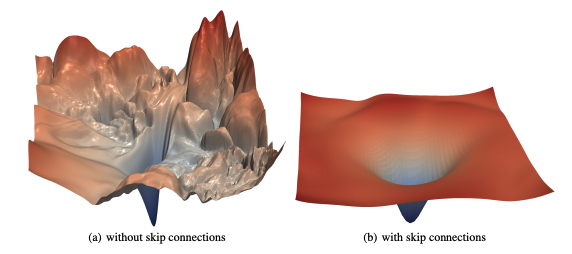

[Source](https://arxiv.org/abs/1712.09913)

### Assembling the Transformer Block

A Transformer Block consists of application of self-attention and MLP with residual connections, stabilized by layer normalization.

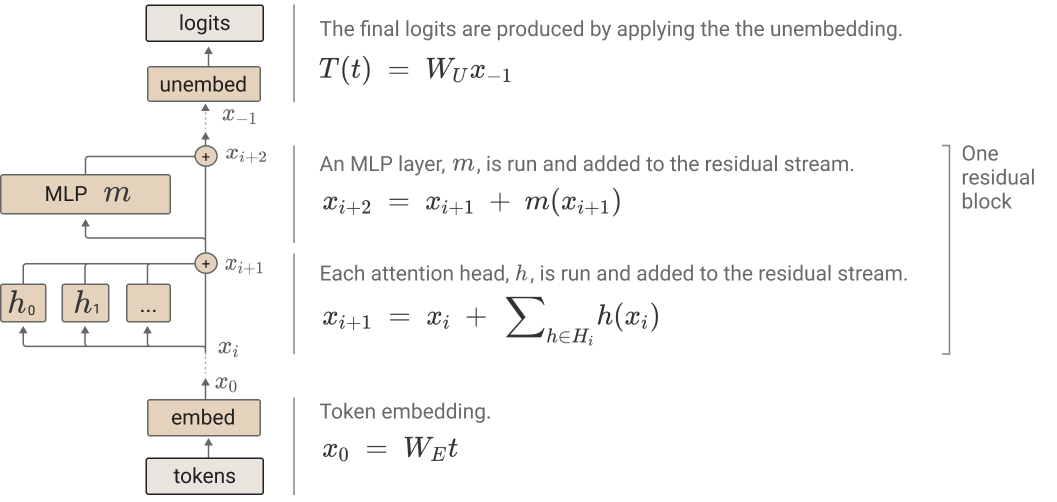
[Source[5]](https://transformer-circuits.pub/2021/framework/index.html)

In [63]:
# Weights for self attention
wK = torch.randn(max_len, emb_dim, dtype=torch.float32)
wQ = torch.randn(max_len, emb_dim, dtype=torch.float32)
wV = torch.randn(max_len, emb_dim, dtype=torch.float32)

wO = torch.randn(max_len, emb_dim, dtype=torch.float32)

# Weights and bias for first MLP layer
w1 = torch.randn(max_len, emb_dim, dtype=torch.float32)
b1 = torch.randn(max_len, 1, dtype=torch.float32).flatten()

# weights and bias for second MLP layer
w2 = torch.randn(emb_dim, max_len, dtype=torch.float32)
b2 = torch.randn(emb_dim, 1, dtype=torch.float32).flatten()

# Learnable parameters for first layer-normalization
gamma1 = torch.ones(emb_dim, dtype=torch.float32)
beta1 = torch.zeros(emb_dim, dtype=torch.float32)

# Learnable parameters for second layer-normalization
gamma2 = torch.ones(emb_dim, dtype=torch.float32)
beta2 = torch.zeros(emb_dim, dtype=torch.float32)

In [64]:
# Embeddings
x = input_embeddings + pe

# Self attention
kx = x @ wK.T
qx = x @ wQ.T
vx = x @ wV.T
v, _ = scaled_dot_product_attention(qx, kx, vx, mask=torch.Tensor(attention_mask).long())
v = v @ wO
v = layer_normalization(v, gamma1, beta1)
print(v.size())
x = x + v

# Two-layer MLP
o = layer_normalization(x, gamma2, beta2)
o = o @ w1.T + b1
o = F.relu(o)
o = o @ w2.T + b2
x = x + nn.Dropout(0.1)(o)

torch.Size([64, 32])


In [65]:
x.size()

torch.Size([64, 32])

### Transformer Block as Pytorch Module

The following is the transformer block as a Pytorch module.

In [66]:
class TransformerBlock(nn.Module):
    def __init__(self, input_dim, num_heads, model_dim, max_len, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention
            model_dim - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(
            input_dim=input_dim, emb_dim=input_dim, num_heads=num_heads, max_len=max_len
        )

        # Two-layer MLP
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, model_dim),
            nn.GELU(),
            nn.Linear(model_dim, input_dim),
            nn.Dropout(dropout)
        )

        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)

    def forward(self, x, mask=None):
        x = x + self.self_attn(self.norm1(x), mask=mask)
        x = x + self.mlp(self.norm2(x))
        return x

## 5. Transformer Architectures - Learning models with different objectives and behaviours

We can now combine all of the ingredients i.e. BPE, token embeddings, positional encoding, self-attention and Transformer blocks to create the Transformer architecture. We can stack multiple Transformer blocks to scale the expressive power of our models.

Generally, we can allow the attention layers to attend to the entire sequence i.e. both the previous and the next words. This setting can be considered as an "encoder", as the model is learning to encode the entire sequence into something meaningful. 

If we limit the attention to only one direction with masking, we call this setting as a "decoder", as the model is learning to look in the past and generate (decode) the next most-likely token.

BERT like models use encoder architecture and language models like GPT use decoder architecture. Both of these settings can be combined as well. Machine Translation models generally use encoder-decoder architecture (as in the original 2017 paper).

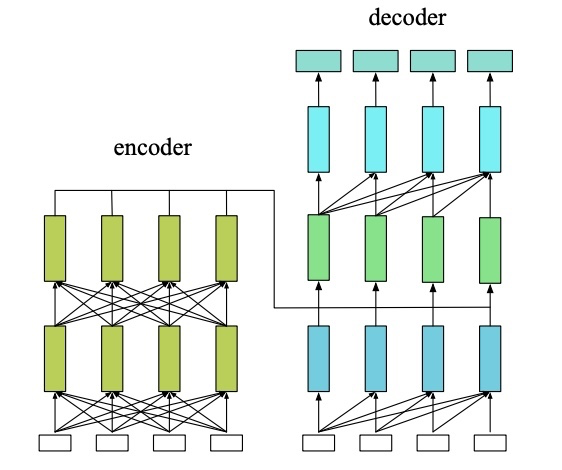

In [67]:
class Transformer(nn.Module):
    def __init__(
        self,
        vocab_size,
        max_len,
        emb_dim,
        model_dim,
        num_layers,
        num_heads,
        dropout=0.1,
        position_sinusoidal=True,
    ):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.input_proj = nn.Linear(emb_dim, model_dim)
        self.positional_encoding = PositionalEncoding(
            model_dim, max_len, sinusoidal=position_sinusoidal
        )
        self.blocks = nn.ModuleList(
            [
                TransformerBlock(model_dim, num_heads, model_dim, max_len, dropout)
                for _ in range(num_layers)
            ]
        )
        self.lm_proj = nn.Linear(model_dim, vocab_size, bias=False)

    def forward(self, input_ids, attention_mask=None, lm_proj=True):
        embeds = self.embedding(input_ids)
        x = self.input_proj(embeds)
        x = self.positional_encoding(x)
        for block in self.blocks:
            x = block(x, mask=attention_mask)

        logits = self.lm_proj(x) if lm_proj else x
        return logits


With causual-attention and by adjusting the `num_layers`, `num_heads` and `model_dim`, most GPT models can be implemented with our code.

In [68]:
gpt2 = dict(num_layers=12, num_heads=12, model_dim=768)  # 120M params
gpt3 = dict(num_layers=96, num_heads=96, model_dim=2048)  # 175B params
gpt_mini = dict(num_layers=6, num_heads=6, model_dim=192) # 1.2M params

In [69]:
model = Transformer(
    vocab_size=vocab_size,
    max_len=max_len,
    emb_dim=32,
    **gpt_mini
)

In [70]:
input_text = 'I am the First Citizen of england'

input_ids, attention_mask = tokenize(input_text,
                     sorted_tokens=sorted_tokens,
                     input_id_map=token2id,
                     return_strings=False,
                     max_length=max_len,
                     unknown_token='</u>')

input_ids = torch.Tensor([input_ids]).long()
attention_mask = torch.Tensor([attention_mask]).long()

In [71]:
model(input_ids, attention_mask).shape

torch.Size([1, 64, 3815])

## 6. Transformer Training - Language Modeling

Now with our Transformer model fully implemented, we can train a GPT-2 like model.

### Dataset for next word prediction

The following creates a pair of inputs, one with sequence from 0 to i index whereas the other going from 1 to i+1 index. The goal of language modeling using next-word prediction is to predict the probability of token i+1, given tokens from 0 to i.

In [1]:
import tiktoken
import random
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from datasets import load_dataset


class NextWordPredictionDataset(Dataset):
    def __init__(
        self,
        dataset="shakespeare",
        max_len=128,
        randomize_seq_len=False,
        return_mask=False,
        idx_offset=0,
    ):
        if dataset == "shakespeare":
            with open("data/shakespeare/train.txt", "r") as f:
                data = " ".join([l for l in f.read().splitlines() if l])
                self.data = data.split(" ")
        elif dataset == "openwebtext":
            self.data = np.memmap(
                "data/openwebtext/train.bin", dtype=np.uint16, mode="r"
            )
        self.dataset = dataset
        self.max_len = max_len
        self.idx_offset = idx_offset
        self.return_mask = return_mask
        self.randomize_seq_len = randomize_seq_len
        self.tokenizer = tiktoken.get_encoding("gpt2")
        self.pad_id = 50256

    def __len__(self):
        return len(self.data) - self.max_len

    def __getitem__(self, idx):
        # Get the index (if offset is larger than length, wrap around).
        idx = idx + self.idx_offset
        # Get the length of tokens/words to get.
        chunk_len = (
            random.randrange(self.max_len) if self.randomize_seq_len else self.max_len
        )

        if self.dataset == "shakespeare":
            tokens = self.tokenizer.encode(
                " ".join(self.data[idx : idx + chunk_len + 1])
            )
        else:
            tokens = self.data[idx : idx + chunk_len + 1].tolist()

        seq_len = min(self.max_len, len(tokens))
        x, y = tokens[:seq_len], tokens[1 : seq_len + 1]
        mask = [1] * len(x)

        for i in range(self.max_len - seq_len + 1):
            if len(x) < self.max_len:
                x.append(self.pad_id)
            if len(y) < self.max_len:
                y.append(self.pad_id)
            if len(mask) < self.max_len:
                mask.append(0)

        x = torch.tensor(x, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.long)

        mask = torch.tensor(mask, dtype=torch.long)
        assert x.size(0) == self.max_len
        assert y.size(0) == self.max_len
        assert mask.size(0) == self.max_len

        if self.return_mask:
            return x, y, mask
        return x, y


In [109]:
train_dataset = NextWordPredictionDataset(
    dataset="openwebtext",
    max_len=4096,
    randomize_seq_len=False,
    return_mask=True,
    idx_offset=0,
)


In [110]:
x, y, mask = train_dataset[100]
x, y, mask

(tensor([   12,   437, 12782,  ...,  3873, 46664,    11]),
 tensor([  437, 12782,   815,  ..., 46664,    11,   284]),
 tensor([1, 1, 1,  ..., 1, 1, 1]))

### Learning rate scheduling

Here we implement a mechanism to gradually lower our learning rate as the training progresses.

In [111]:
import torch.optim as optim

class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters, min_lr_factor=0.1):
        self.warmup = warmup
        self.max_num_iters = max_iters
        self.min_lr_factor = min_lr_factor
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return max(lr_factor, self.min_lr_factor)

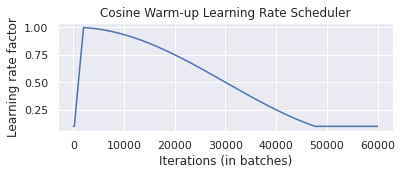

In [112]:
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=6e-4)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=2000, max_iters=60000)

steps = list(range(60000))
sns.set()
plt.figure(figsize=(6,2))
plt.plot(steps, [lr_scheduler.get_lr_factor(e) for e in steps])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

### Defining the model and training

The following is the implementation of GPT2 model with training and optimzation configuration.

In [73]:
import pytorch_lightning as pl


class GPT2(pl.LightningModule):
    def __init__(
        self,
        max_len=64,
        emb_dim=128,
        num_layers=6,
        num_heads=6,
        model_dim=128,
        vocab_size=50257,
        lr=6e-4,
        warmup=2000,
        weight_decay=1e-2,
        dropout=0.0,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.model = model = Transformer(
            vocab_size=vocab_size,
            max_len=max_len,
            emb_dim=emb_dim,
            model_dim=model_dim,
            num_layers=num_layers,
            num_heads=num_heads,
            dropout=dropout,
            position_sinusoidal=False
        )

    def training_step(self, batch, batch_idx):
        input_ids, targets = batch
        logits = self.model(input_ids=input_ids, attention_mask=None)
        loss = F.cross_entropy(
            logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1
        )
        self.log("train_loss", loss)
        # if self.global_step % 20000 == 0:
        #     self.trainer.save_checkpoint("gpt2-openwebtext.ckpt")
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
            betas=(0.9, 0.95)
        )

        lr_scheduler = CosineWarmupScheduler(
            optimizer,
            warmup=self.hparams.warmup,
            max_iters= self.trainer.max_steps
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]


In [117]:
config = dict(
    max_len=1024,
    emb_dim=768,
    num_layers=12,
    num_heads=12,
    model_dim=768,
    vocab_size=50257,
    weight_decay=0.1,
    dropout=0.0
) # gtp2

model = GPT2(**config)

In [118]:
train_dataset = NextWordPredictionDataset(dataset="openwebtext", max_len=1024, idx_offset=0)
train_loader = DataLoader(
    train_dataset,
    shuffle=False,
    pin_memory=False,
    batch_size=12,
    num_workers=60,
)

In [ ]:
trainer = pl.Trainer(
    max_steps=600000,
    accumulate_grad_batches=10,
    accelerator="gpu",
    devices=-1,
    strategy="dp",
)

In [ ]:
trainer.fit(model, train_loader)

In [ ]:
trainer.save_checkpoint("gpt2-openwebtext.ckpt")

### Generating new tokens with trained model

Now lets use our trained model to generate new tokens by sampling from the vocabulary following the distribution generated by our model.

In [119]:
model = GPT2.load_from_checkpoint("gpt2-openwebtext.ckpt")

In [120]:
 def generate(model, prompt, max_new_tokens, temperature=1.0):
    
    model.to('cpu').eval()
    tokenizer = tiktoken.get_encoding("gpt2")
    ids = tokenizer.encode(prompt)
    
    for _ in range(max_new_tokens):
        logits = model.model(torch.Tensor([ids]).long())
        probs = F.softmax(logits[:, -1, :] / temperature, dim=-1) 
        idx_next = torch.multinomial(probs, num_samples=1)
        ids.append(idx_next)
    
    return tokenizer.decode(ids)

In [121]:
prompt = "Hello my name is "

In [122]:
generation = generate(model, prompt, max_new_tokens=30, temperature=0.8)
print(generation)

Hello my name is  - which she had a slow start here if the U.


 resources international H Hurricane link to the farther anotherlaugh will provide a single aircraft


## References

[1] https://leimao.github.io/blog/Byte-Pair-Encoding/

[2] https://github.com/karpathy/minGPT

[3] https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a

[4] https://transformer-circuits.pub/